In [1]:
import requests
import json
import rasterio as rio
import rioxarray as rxr
import pandas as pd
from files import dsm_df
from files import dtm_df

import matplotlib.pyplot as plt
import earthpy.plot as ep
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import geopandas as gpd

import plotly.graph_objects as go

import numpy as np


In [6]:
# street='Sint-Pietersvliet'
# number='7'
# post='2000'

In [46]:
street='Vleeshouwersstraat'
number='38'
post='2000'

In [47]:
polygone=[]

In [84]:
def house_info(street, number, post):
    a=requests.get('https://api.basisregisters.dev-vlaanderen.be/v1/adressen?'+'straatnaam='+street+'&huisnummer='+number+'&postcode='+post+'&limit=1')
    b=a.json()
    id1= b['adressen'][0]['identificator']['objectId']
    print('Address found: Id1 is',id1)
    c=requests.get('https://api.basisregisters.vlaanderen.be/v1/gebouweenheden?adresObjectId='+id1)
    d=c.json()
    id2= d['gebouweenheden'][0]['identificator']['objectId']
    print('Building units found: Id2 is',id2)
    e=requests.get('https://api.basisregisters.vlaanderen.be/v1/gebouweenheden/'+id2)
    f=e.json()
    id3= f['gebouw']['objectId']
    print('Building found: Id3 is',id3)
    g=requests.get('https://api.basisregisters.vlaanderen.be/v1/gebouwen/'+id3)
    h=g.json()
    poly=h['geometriePolygoon']['polygon']['coordinates'][0]
    polygone.append(poly)

In [85]:
house_info(street, number, post)

Address found: Id1 is 1951291
Building units found: Id2 is 15779926
Building found: Id3 is 15778838


In [82]:
x=polygone[0][0][0]
y=polygone[0][0][1]


In [13]:
file_dsm_selected = dsm_df.loc[
    (x < dsm_df.xmax) & (x > dsm_df.xmin) & (y < dsm_df.ymax) & (y > dsm_df.ymin)
]

dsm_selected = file_dsm_selected.index.format()[0]


In [15]:
file_dtm_selected = dtm_df.loc[
    (x < dtm_df.xmax) & (x > dtm_df.xmin) & (y < dtm_df.ymax) & (y > dtm_df.ymin)
]
dtm_selected = file_dtm_selected.index.format()[0]

In [16]:
read_dsm = rxr.open_rasterio("DSM/" + dsm_selected, masked=True).squeeze()
read_dtm = rxr.open_rasterio("DTM/" + dtm_selected, masked=True).squeeze()

In [17]:
print("Is the spatial extent the same?", read_dsm.rio.bounds() == read_dtm.rio.bounds())

Is the spatial extent the same? True


In [19]:
k15=  read_dsm - read_dtm

In [15]:
k15.rio.to_raster("k15.tif")

In [50]:
geometries = [
    {
        'type': 'Polygon',
        'coordinates': polygone
    }
]

In [58]:
clipped = rxr.open_rasterio("k15.tif", masked=True).rio.clip(geometries, from_disk=True)

(array([879.,   1.,   3.,   8.,   9., 119., 164., 140., 152.,  65.]),
 array([ 0.        ,  3.22247314,  6.44494629,  9.66741943, 12.88989258,
        16.11236572, 19.33483887, 22.55731201, 25.77978516, 29.0022583 ,
        32.22473145]),
 <BarContainer object of 10 artists>)

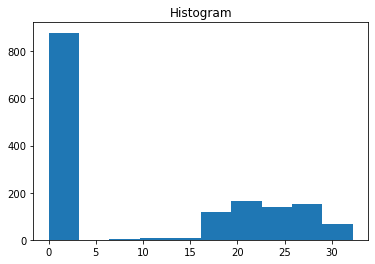

In [59]:
clipped.plot.hist()

In [86]:
clipped.rio.to_raster("clipped.tif")

In [62]:
with rio.open("clipped.tif") as img:
    chm = img.read(1)

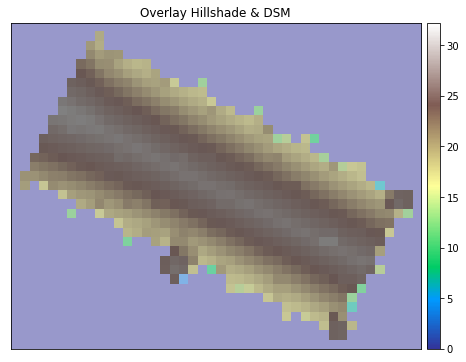

In [69]:
fig, ax = plt.subplots(figsize=(10, 6))
ep.plot_bands(
    chm, ax=ax, cmap="terrain", title="Overlay Hillshade & DSM",
)
ax.imshow(chm, cmap="Greys", alpha=0.5)
plt.show()


In [56]:
chm_gdp = gpd.GeoDataFrame(chm)


In [57]:
z_data = chm_gdp
z = z_data.values
sh_0, sh_1 = z.shape
x, y = np.linspace(0, 1, sh_0), np.linspace(0, 1, sh_1)
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
fig.update_layout(title='House', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

In [83]:
print('Altitude:',np.amax(z),'m')
print('Coordinates:',x,',',y)

Altitude: 32.2247314453125 m
Coordinates: 152120.51700472087 , 212541.82696551457


In [87]:
#trying wms geopunt
from owslib.wms import WebMapService


In [91]:
wms = WebMapService('https://geoservices.informatievlaanderen.be/raadpleegdiensten/DHMV/wms?service=WMS&request=getcapabilities')

In [92]:
list(wms.contents)

['DHMV',
 'DHMVII',
 'DHMVII_vdc',
 'DHMVII_DSM_1m',
 'DHMVII_DTM_1m',
 'DHMV_II_HILL_25cm',
 'DHMV_II_SVF_25cm',
 'DHMVI',
 'DHMVI_vdc',
 'DHMVI_DTM_5m']

In [93]:
wms['DHMVII_DSM_1m'].title

'Digitaal Hoogtemodel Vlaanderen II, digitaal oppervlaktemodel 1m'

In [95]:
wms['DHMVII_DSM_1m'].boundingBox

(2.52, 50.64, 5.94, 51.51, 'EPSG:4258')

In [96]:
wms['DHMVII_DSM_1m'].styles

{'default': {'title': 'DHMVII_DSM_1m',
  'legend': 'https://geoservices.informatievlaanderen.be/raadpleegdiensten/DHMV/wms?request=GetLegendGraphic%26version=1.3.0%26format=image/png%26layer=DHMVII_DSM_1m'}}

In [97]:
[op.name for op in wms.operations]

['GetCapabilities', 'GetMap', 'GetFeatureInfo', 'GetStyles']